# Analysis of Patterns Learned By SSL

In [12]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [28]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
#import umap
from ulmo import io as ulmo_io
from ulmo.ssl.train_util import modis_loader, set_model
from ulmo.ssl.train_util import Params, option_preprocess
from ulmo.ssl import latents_extraction

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import trange

In [14]:
from torchvision import utils

In [15]:
### set the model path and read the model file
model_path = '/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl/experiments/llc_modis_2012/'

In [16]:
files_list = os.listdir(os.path.join(model_path, os.listdir(model_path)[1]))

In [17]:
file = files_list[-1]

In [18]:
file_path = os.path.join(model_path, os.listdir(model_path)[1], file)

In [20]:
model_dict = torch.load(file_path, map_location=torch.device('cpu'))

In [21]:
weights_model = model_dict['model']

In [22]:
conv_keys = [key for key in list(weights_model.keys()) if 'conv' in key]

In [82]:
weights_conv1_key = conv_keys[0]

In [83]:
weights_conv1 = weights_model[weights_conv1_key]

In [127]:
conv_keys[0]

'encoder.module.conv1.weight'

## We note here that the dimension of the filters are as follows,
### [input_channels, output_channels, conv_size[0], conv_size[1]]

In [25]:
def load_palette(pfile=None):
    """ Load the color pallette
    Args:
        pfile (str, optional): Filename of the pallette. Defaults to None.
    Returns:
        color pallette, LinearSegmentedColormap: pallette for sns, colormap
    """
    
    if pfile is None:
        pfile = os.path.join(resource_filename('ulmo', 'plotting'), 'color_palette.txt')
    # Load me up
    with open(pfile, 'r') as f:
        colors = np.array([l.split() for l in f.readlines()]).astype(np.float32)
        pal = sns.color_palette(colors)
        boundaries = np.linspace(0, 1, 64)
        colors = list(zip(boundaries, colors))
        cm = LinearSegmentedColormap.from_list(name='rainbow', colors=colors)
    return pal, cm

In [29]:
_, cm = load_palette()

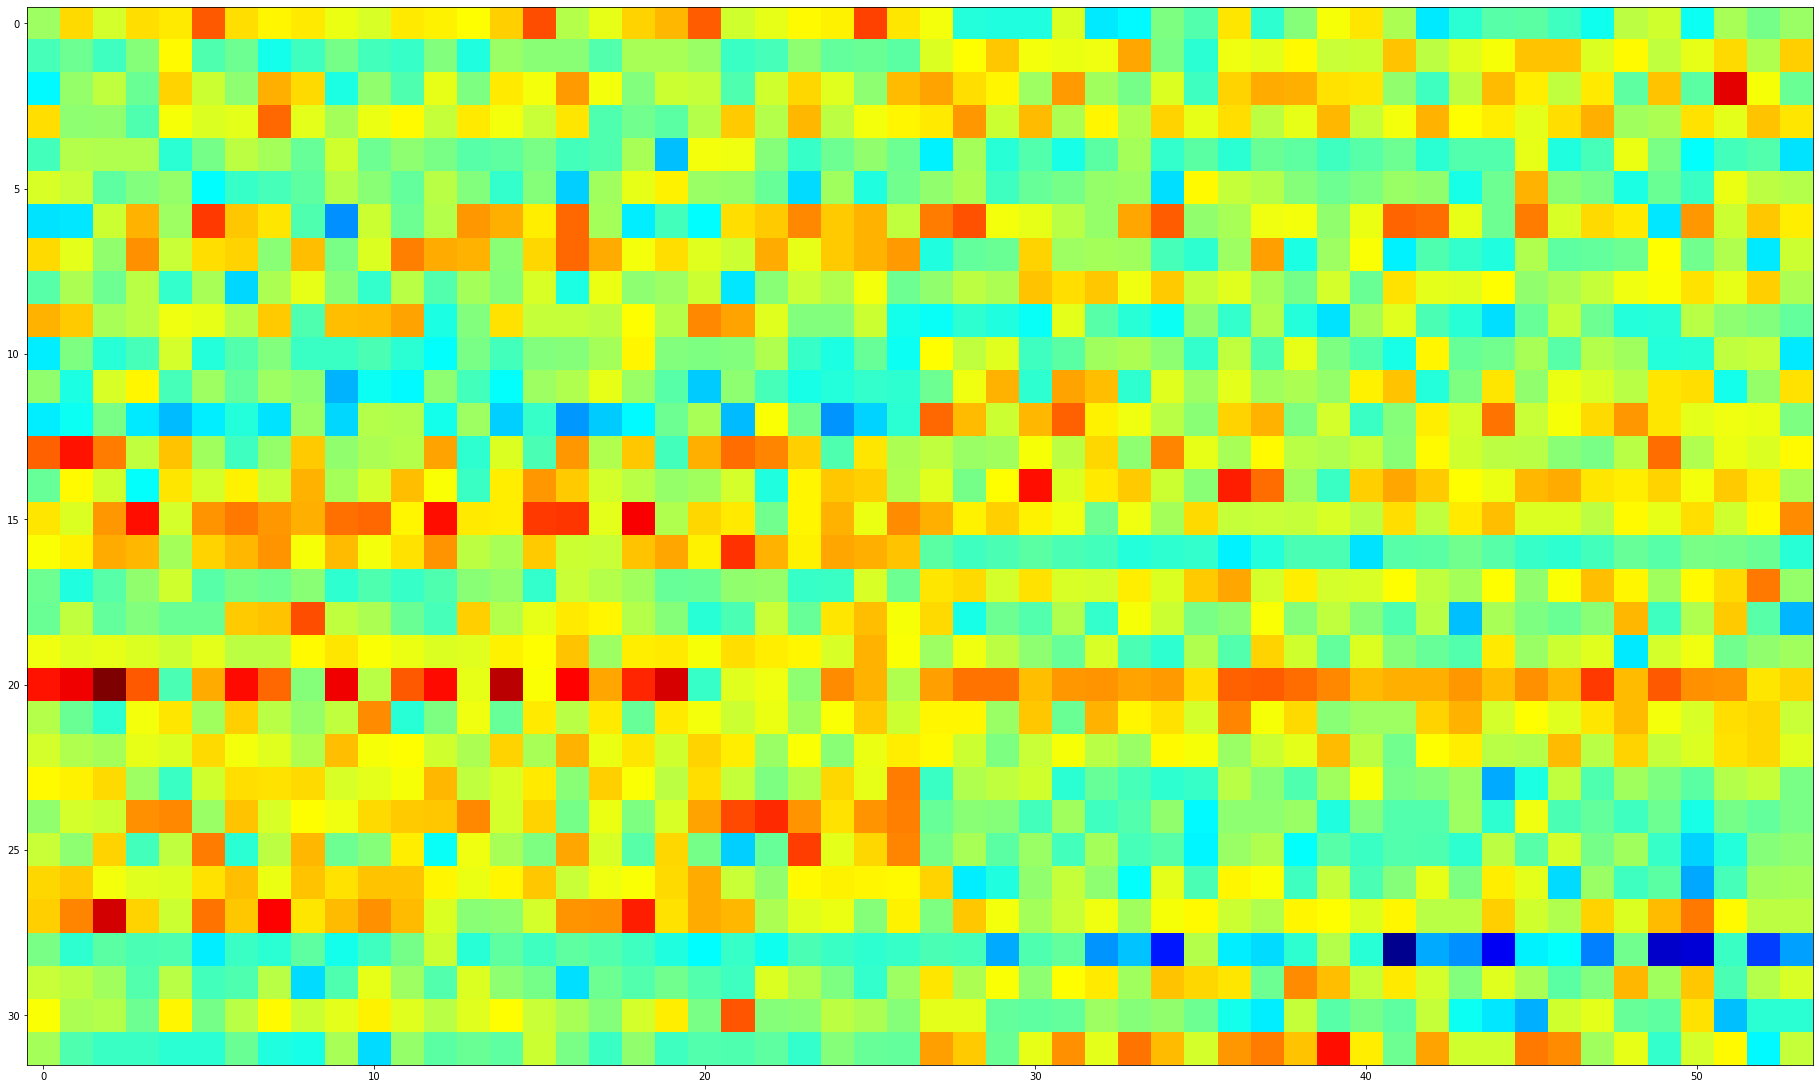

In [88]:
plt.figure(figsize=(32, 54))
plt.imshow(weights_conv1.reshape((32, 54)).numpy(), cmap=cm)

In [91]:
def visTensor(tensor, ch=0, allkernels=False, nrow=16, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow*2, rows*2) )
        plt.imshow(grid.numpy().transpose(1, 2, 0), cmap=cm)

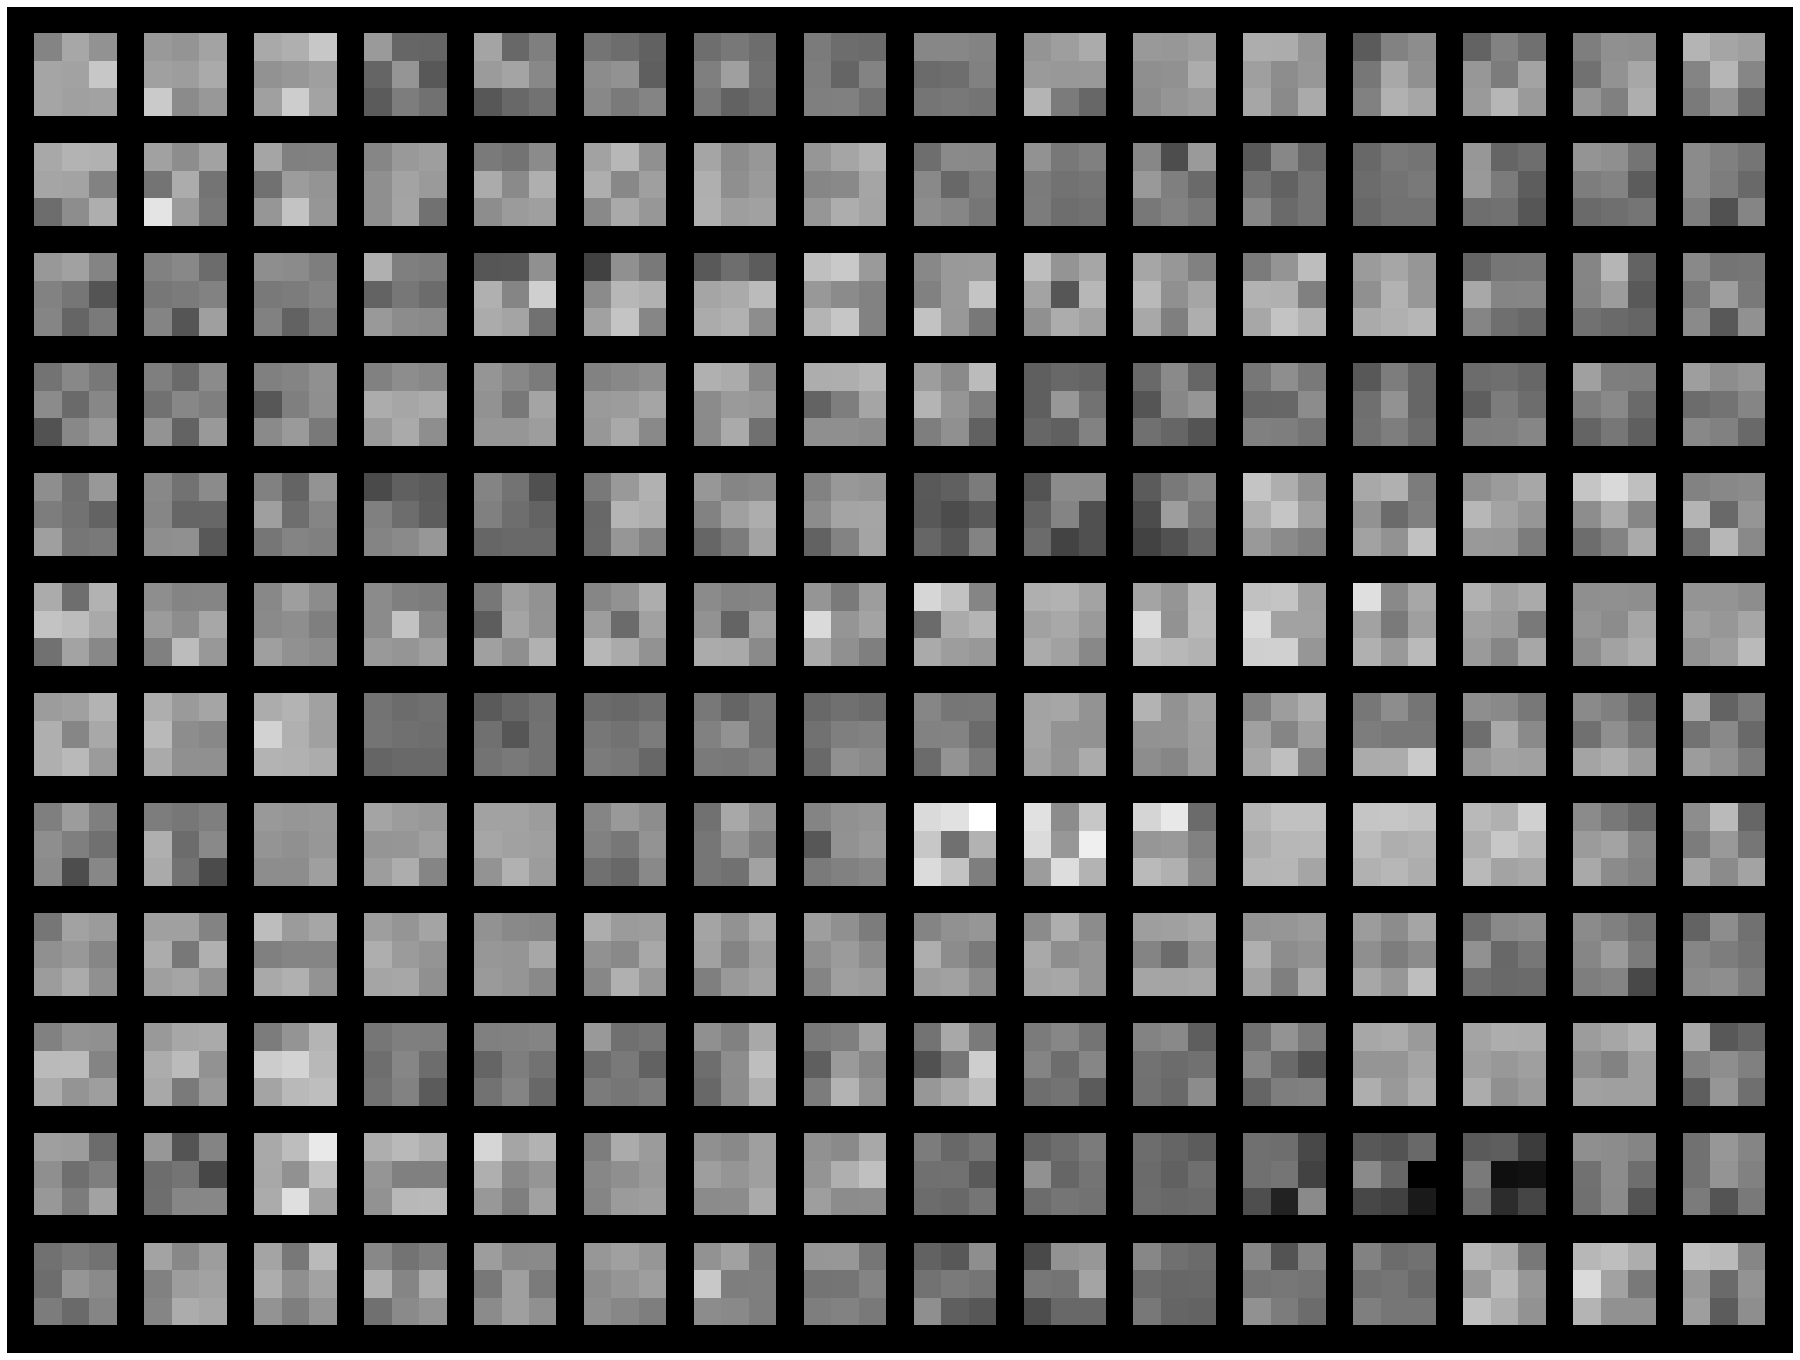

In [92]:
visTensor(weights_conv1, allkernels=True)
plt.axis('off')
plt.ioff()
plt.show()

In [52]:
weights_conv2_key = conv_keys[1]
weights_conv2 = weights_model[weights_conv2_key]

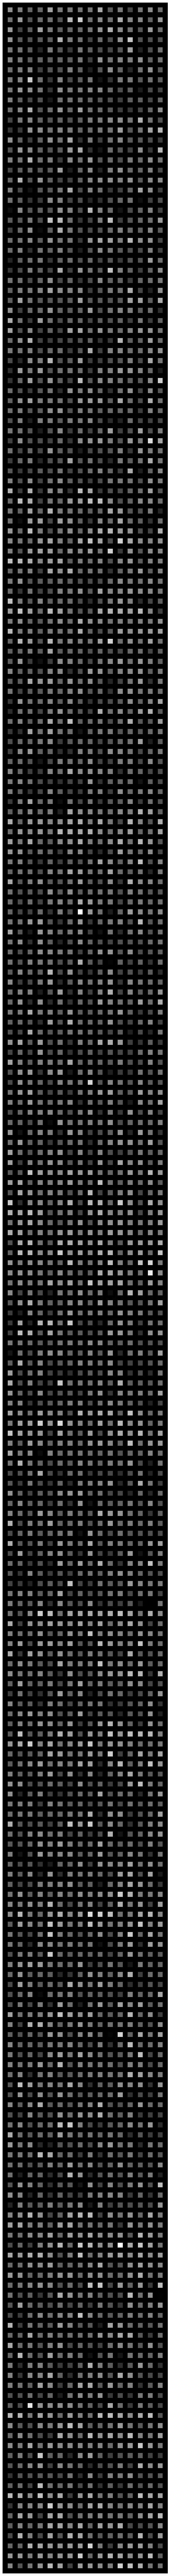

In [53]:
visTensor(weights_conv2, allkernels=True)
plt.axis('off')
plt.ioff()
plt.show()

In [76]:
weights_conv3_key = conv_keys[2]
weights_conv3 = weights_model[weights_conv3_key]

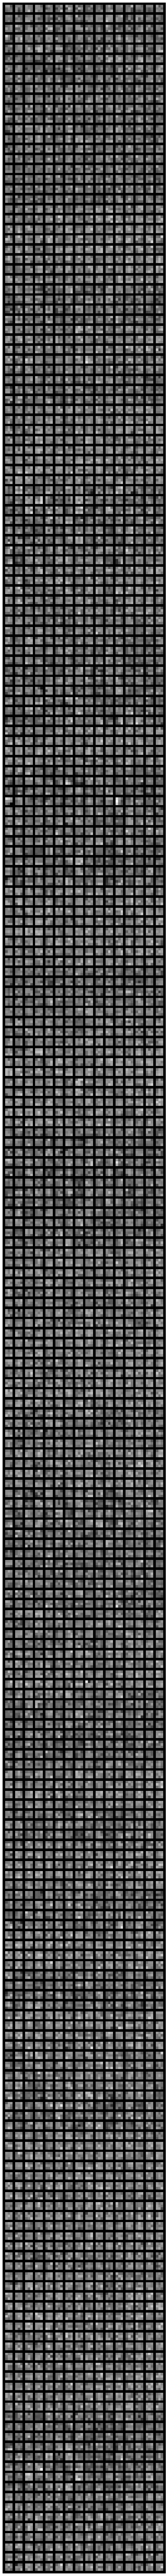

In [77]:
visTensor(weights_conv3, allkernels=True)
plt.axis('off')
plt.ioff()
plt.show()

## Gallery of the Conv2D filters

In [118]:
weights_conv1_reshape = np.reshape(weights_conv1, (16, 12, 9))

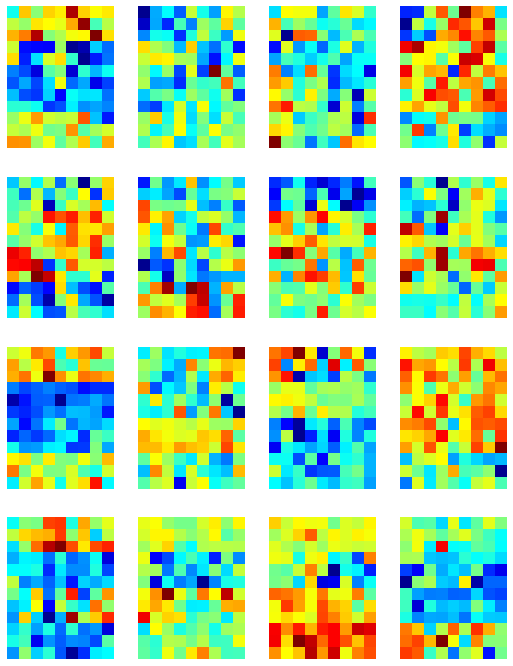

In [121]:
plt.figure(figsize=(9, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    conv_weight = weights_conv1_reshape[i]
    plt.imshow(conv_weight, cmap=cm)
    plt.axis('off')

In [122]:
weights_conv2_key = conv_keys[1]
weights_conv2 = weights_model[weights_conv2_key]

### Show the conv2d with 1x1

In [123]:
weights_conv2.shape

torch.Size([64, 64, 1, 1])

In [125]:
weights_conv2_reshape = weights_conv2.reshape(64, 8, 8)

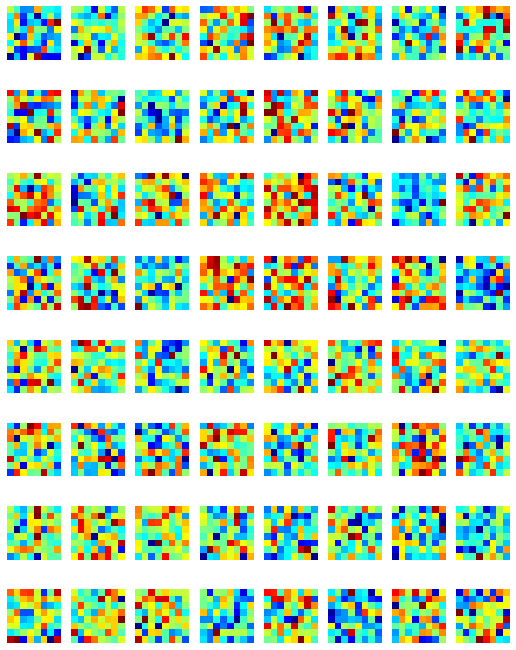

In [126]:
plt.figure(figsize=(9, 12))
for i in range(64):
    plt.subplot(8, 8, i+1)
    conv_weight = weights_conv2_reshape[i]
    plt.imshow(conv_weight, cmap=cm)
    plt.axis('off')

In [166]:
weights_conv2_reshape_1 = weights_conv2.reshape(16, 16, 16)

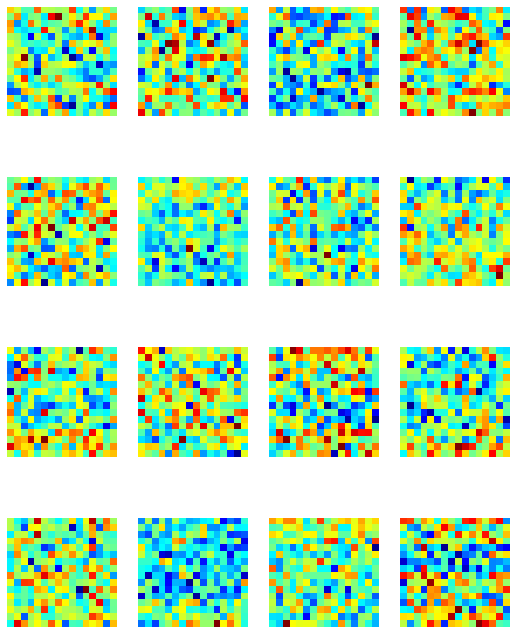

In [167]:
plt.figure(figsize=(9, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    conv_weight = weights_conv2_reshape_1[i]
    plt.imshow(conv_weight, cmap=cm)
    plt.axis('off')

In [142]:
head2_layer_key = list(weights_model.keys())[-2]
head0_layer_key = list(weights_model.keys())[-4]

In [143]:
weights_head2 = weights_model[head2_layer_key]

In [145]:
weights_head2.shape

torch.Size([256, 2048])

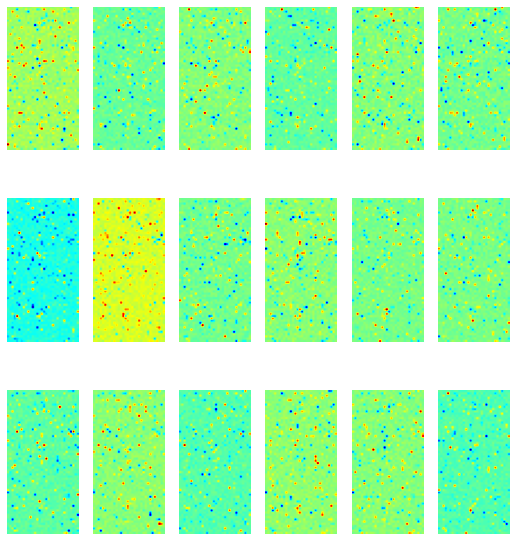

In [160]:
plt.figure(figsize=(9, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    weights_head2_slide = weights_head2[i]
    weights_head2_slide_reshape = weights_head2_slide.reshape((64, 32))
    plt.imshow(weights_head2_slide_reshape, cmap=cm)
    plt.axis('off')

In [161]:
weights_head0 = weights_model[head0_layer_key]

In [162]:
weights_head0.shape

torch.Size([2048, 2048])

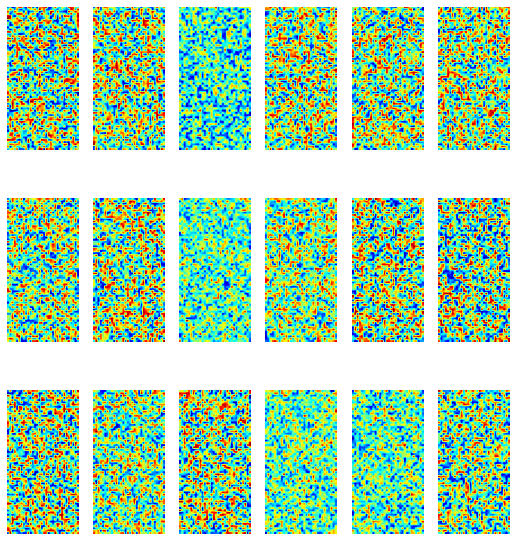

In [165]:
plt.figure(figsize=(9, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    weights_head0_slide = weights_head0[i]
    weights_head0_slide_reshape = weights_head0_slide.reshape((64, 32))
    plt.imshow(weights_head0_slide_reshape, cmap=cm)
    plt.axis('off')